In [16]:
import torch
from torch import nn

## Lenet

In [17]:
import torchvision as tv
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
BATCH_SIZE=256

In [47]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [7]:
train_dataset[0][0].numpy().reshape(28,28)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

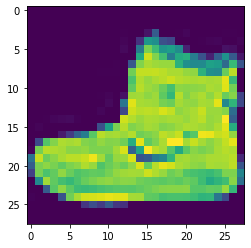

In [20]:
fig, ax = plt.subplots()
ax.imshow(train_dataset[0][0].numpy().reshape(28,28))

In [48]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(400, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

In [49]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)). X shape: torch.Size([1, 6, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 6, 28, 28])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 6, 14, 14])
Layer Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)). X shape: torch.Size([1, 16, 10, 10])
Layer ReLU(). X shape: torch.Size([1, 16, 10, 10])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 16, 5, 5])
Layer Flatten(). X shape: torch.Size([1, 400])
Layer Linear(in_features=400, out_features=100, bias=True). X shape: torch.Size([1, 100])
Layer ReLU(). X shape: torch.Size([1, 100])
Layer Linear(in_features=100, out_features=10, bias=True). X shape: torch.Size([1, 10])


In [50]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
y = model(X)
print(y.shape)

torch.Size([1, 10])


## Обучение на GPU

In [51]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [52]:
dev

device(type='cuda')

In [53]:
model = model.to(dev)

In [54]:
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [55]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [57]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, dev)

epoch 1, loss 0.2915, train acc 0.894, test acc 0.875, time 10.0 sec
epoch 2, loss 0.2822, train acc 0.897, test acc 0.877, time 9.9 sec
epoch 3, loss 0.2746, train acc 0.899, test acc 0.882, time 9.4 sec
epoch 4, loss 0.2678, train acc 0.901, test acc 0.887, time 9.4 sec
epoch 5, loss 0.2612, train acc 0.904, test acc 0.889, time 9.5 sec
epoch 6, loss 0.2552, train acc 0.906, test acc 0.889, time 9.3 sec
epoch 7, loss 0.2499, train acc 0.908, test acc 0.892, time 9.6 sec
epoch 8, loss 0.2447, train acc 0.910, test acc 0.893, time 10.1 sec
epoch 9, loss 0.2399, train acc 0.911, test acc 0.893, time 10.1 sec
epoch 10, loss 0.2355, train acc 0.914, test acc 0.896, time 12.5 sec
